In [16]:
import os
from os import listdir, makedirs, getcwd
import shutil
from os.path import exists, isdir, join, abspath
from pathlib import Path
import pandas as pd 
import seaborn as sns
from PIL import Image
from skimage.io import imread
import cv2
import matplotlib.image as mimg
import numpy as np 
import matplotlib.pyplot as plotter
from mpl_toolkits.mplot3d import Axes3D 
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers

# training set manipulaton
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import math

In [20]:
from google.colab import drive
drive_root_folder= '/content/gdrive/'
drive.mount(drive_root_folder)

print(os.listdir(drive_root_folder +'Othercomputers/DavideLaptop/Desktop'))


flowersPath = Path(drive_root_folder + 'Othercomputers/DavideLaptop/Desktop/flowersData')

flowers = os.listdir(flowersPath)
print("Number of types of flowers: ", len(flowers))
print("Types of flowers: ", flowers)
# A list which contains tuples, the type of flower and the corresponding image path
flowersList = []

for species in flowers:
    allFlowers = os.listdir(flowersPath / species)
    # Add flowers images to the list
    for flower in allFlowers:
        flowersList.append((species, str(flowersPath /species) + '/' + flower))

flowersListDataframe = pd.DataFrame(data=flowersList, columns=['category', 'image'], index=None)
flowersListDataframe.head()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
['Documenti', 'pagella.pdf', 'pianoStudi.pdf', 'Certificazioni', 'b2 inglese', 'flowersData', 'Davide-Claudia Documents', 'FamilyPollicinoDocuments', 'budgeting', 'model_classifier', 'flowers_splitted', 'IrisClassification', 'classifier.pkl']
Number of types of flowers:  5
Types of flowers:  ['tulip', 'sunflower', 'daisy', 'rose', 'dandelion']


,category,image
0,tulip,/content/gdrive/Othercomputers/DavideLaptop/De...
1,tulip,/content/gdrive/Othercomputers/DavideLaptop/De...
2,tulip,/content/gdrive/Othercomputers/DavideLaptop/De...
3,tulip,/content/gdrive/Othercomputers/DavideLaptop/De...
4,tulip,/content/gdrive/Othercomputers/DavideLaptop/De...


Total number of flowers in the dataset:  3959
Flowers in each category: tulip        984
rose         784
daisy        769
sunflower    734
dandelion    688
Name: category, dtype: int64


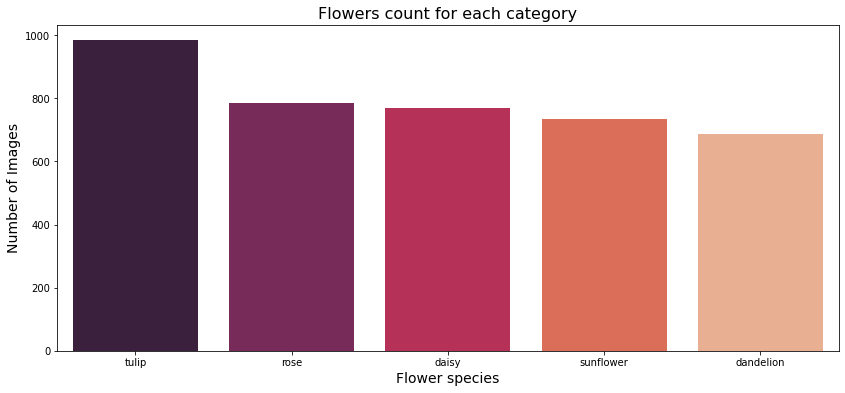

In [29]:
# Provides information about current datase classes
print("Total number of flowers in the dataset: ", len(flowersList))
flowerNum = flowersListDataframe['category'].value_counts()
print("Flowers in each category: " + str(flowerNum))

# A list for storing names of some random samples from each category
RanSamples = []

# Get samples fom each category 
for category in flowerNum.index:
    samples = flowersListDataframe['image'][flowersListDataframe['category'] == category].sample(4).values
    for sample in samples:
        RanSamples.append(sample)

# Data distribution visualization before dataset splitting
y, axe = plotter.subplots(1,1,figsize=(14,6))
sns.barplot(x = flowerNum.index, y = flowerNum.values, ax = axe, palette="rocket")
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Flower species', fontsize=14)
axe.set_ylabel('Number of Images', fontsize=14)
plotter.show()

In [ ]:
# Make directory 'test', with 2 sub directories, 'trainDir', & 'validDir'
trainDir = './test/trainDir'
valDir = './test/valDir'
# test_dir = './test/test_dir'
def create_directory(dirName):
    if os.path.exists(dirName):
        shutil.rmtree(dirName)
    os.makedirs(dirName)
    # Inside the trainDir & valDir sub-directories, sub-directories for each flower is created
    for flower in flowers:
        os.makedirs(os.path.join(dirName, flower))
create_directory(trainDir)
create_directory(valDir)


# lists for training & validation image & label
trainImg = []
trainLabel = []
validImg = []
validLabel = []

flower_identification = {}

# for copying 100 samples to the validation dir & others to the train dir
for flower in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == flower].values
    diffPics = np.random.permutation(samples)
    
    for i in range(100):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./test/valDir/' + str(flower) + '/'+ name)
        
        try:
            # add image to list
            img = plotter.imread('./test/valDir/' + str(flower) + '/'+ name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            validImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                validLabel.append(0)
                flower_identification[0] = 'Dandelion'
            elif (str(flower)=="tulip"):
                validLabel.append(1)
                flower_identification[1] = 'Tulip'
            elif (str(flower)=="rose"):
                validLabel.append(2)
                flower_identification[2] = 'Rose'
            elif (str(flower)=="daisy"):
                validLabel.append(3)
                flower_identification[3] = 'Daisy'
            elif (str(flower)=="sunflower"):
                validLabel.append(4)
                flower_identification[4] = 'Sunflower'
        except Exception as e:
            None
        
    for i in range(101,len(diffPics)):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./test/trainDir/' + str(flower) + '/' + name)

        try:
            # add image to list
            img = plotter.imread('./test/trainDir/' + str(flower) + '/' + name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            trainImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                trainLabel.append(0)
            elif (str(flower)=="tulip"):
                trainLabel.append(1)
            elif (str(flower)=="rose"):
                trainLabel.append(2)
            elif (str(flower)=="daisy"):
                trainLabel.append(3)
            elif (str(flower)=="sunflower"):
                trainLabel.append(4)
        except Exception as e:
            None
           
# Let computer read the 5 category
validLabel = to_categorical(validLabel,num_classes = 5)
trainLabel = to_categorical(trainLabel,num_classes = 5)
print(validLabel)
print(trainLabel)

# Make new test and validation images as pixcel
validImg=np.array(validImg)
validImg=validImg/255

trainImg=np.array(trainImg)
trainImg=trainImg/255

print("\nLengths of the corresponding array dimensions: \n")
print(np.shape(validImg),np.shape(validLabel),np.shape(trainImg),np.shape(trainLabel))

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

Lengths of the corresponding array dimensions: 

(500, 150, 150, 3) (500, 5) (3453, 150, 150, 3) (3453, 5)


In [ ]:
"""
from google.colab import auth 
auth.authenticate_user()

project_id = 'plant-classifier'
!gcloud config set project {project_id}

bucket_name = 'plant-identification-bucket'

def deployModel(model):
    SAVED_MODEL_DIR=$(ls./your-model-export-dir|tail-1) 
    !gsutil cp -r $SAVED_MODEL_DIR gs://bucket_name 
"""
def createModel():
    model = Sequential()
    #  learn a total of 32 filters, kernel size 3x3
    model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 64 filters, kernel size 3x3
    model.add(Conv2D(64, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 96 filters, kernel size 3x3
    model.add(Conv2D(96, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #  learn a total of 128 filters, kernel size 3x3
    model.add(Conv2D(128, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add Dense layers on top
    '''
    1. flatten the 3D output to 1D
    2. add dense layer to top
    '''
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
!pip install pyyaml h5py

In [ ]:
# Compile
import pickle
model = createModel()
batch_size = 128
epochs = 50

model.compile(loss='categorical_crossentropy',
             optimizer='RMSProp',
             metrics=['accuracy'])

# Create data argument to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (90, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        shear_range=0.1,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)
datagen.fit(trainImg)

# start training
'''
verbose - 0 shows nothing; 1 will show animated progress bar; 2 will only mention the number of epoch.
batch_size - the number of samples that will be propagated through the network.
epochs - an arbitrary cutoff, use to separate training into distinct phases.
'''
History = model.fit(trainImg, trainLabel, batch_size=batch_size, epochs = epochs, validation_data = (validImg, validLabel),verbose=1)
model.save('/content/gdrive/Othercomputers/DavideLaptop/Desktop/model_classifier')
pickle.dump(model, open('/content/gdrive/Othercomputers/DavideLaptop/Desktop/classifier.pkl','wb'))
model.summary()



Epoch 1/50
27/27 [==============================] - 190s 7s/step - loss: 1.7856 - accuracy: 0.2986 - val_loss: 1.4096 - val_accuracy: 0.4720
Epoch 2/50
27/27 [==============================] - 189s 7s/step - loss: 1.2665 - accuracy: 0.4726 - val_loss: 1.3195 - val_accuracy: 0.4300
Epoch 3/50
27/27 [==============================] - 157s 6s/step - loss: 1.1498 - accuracy: 0.5323 - val_loss: 0.9779 - val_accuracy: 0.6060
Epoch 4/50
27/27 [==============================] - 161s 6s/step - loss: 1.0665 - accuracy: 0.5757 - val_loss: 0.9392 - val_accuracy: 0.5880
Epoch 5/50
27/27 [==============================] - 157s 6s/step - loss: 0.9641 - accuracy: 0.6247 - val_loss: 0.8530 - val_accuracy: 0.6640
Epoch 6/50
27/27 [==============================] - 157s 6s/step - loss: 0.9049 - accuracy: 0.6583 - val_loss: 0.8353 - val_accuracy: 0.6760
Epoch 7/50
27/27 [==============================] - 157s 6s/step - loss: 0.8409 - accuracy: 0.6855 - val_loss: 0.8111 - val_accuracy: 0.6820
Epoch 8/50
27

In [ ]:
# Save and Load mode
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plotter
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


img_path = "/content/gdrive/Othercomputers/DavideLaptop/Desktop/flowersData/sunflower/23286304156_3635f7de05.jpg"
plotter.show(img_path)
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
# img_preprocessed = preprocess_input(img_batch)

# load model here 
prediction = model.predict(img_batch)
pred_digits=np.argmax(prediction,axis=1)
print(pred_digits)
# Name of the predicted flower
print('Plant name: ' + flower_identification[pred_digits[0]])
# Get Percentage of predictions 
predict_classes=np.argmax(prediction,axis=1)
print(predict_classes)

 
# Printing the input tensor
print('labels: ',trainLabel)
print('Predictions: ',prediction)
 


[4]
Plant name: Sunflower
[4]
labels:  [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Predictions:  [[0. 0. 0. 0. 1.]]


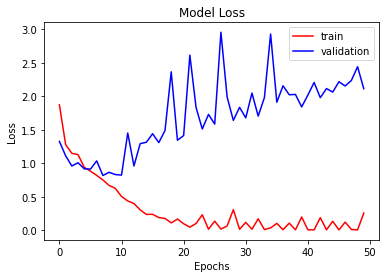

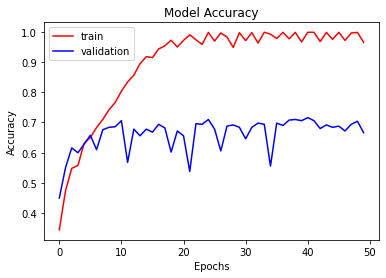

In [ ]:
# Shows Accuracy trends during training phase
plotter.plot(History.history['accuracy'], "r")
plotter.plot(History.history['val_accuracy'],"b")
plotter.title('Shows Accuracy trends during training phase')
plotter.xlabel('Epochs')
plotter.ylabel('Accuracy value')
plotter.legend(['train', 'validation'])
plotter.show()

# Shows loss value trends during training phase
plotter.plot(History.history['loss'], "r")
plotter.plot(History.history['val_loss'], "b")
plotter.title('Shows loss value trends during training phase')
plotter.xlabel('Epoch value')
plotter.ylabel('Loss value')
plotter.legend(['train', 'validation'])
plotter.show()



In [ ]:
# Load ML model and make a prediction
import pickle
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plotter
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
filename = '/content/gdrive/Othercomputers/DavideLaptop/Desktop/flowersData/sunflower/23286304156_3635f7de05.jpg'
model = pickle.load(open('/content/gdrive/Othercomputers/DavideLaptop/Desktop/classifier.pkl', 'rb'))

img_path = "/content/gdrive/Othercomputers/DavideLaptop/Desktop/flowersData/sunflower/23286304156_3635f7de05.jpg"
plotter.show(img_path)
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_batch)
pred_digits=np.argmax(prediction,axis=1)
print(pred_digits)
# Name of the predicted flower
# print('Plant name: ' + flower_identification[pred_digits[0]])


[4]
